# **EDA y pipeline para MVP inicial de SmartStock AI**


_Equipo SmartStock AI_  
_Para Hackathon NODO 2026_  

El proyecto ***SmartStock AI*** es un ***sistema de optimización inteligente de inventarios*** diseñado para ***Pymes de retail y e-commerce***. Fue creado para la ***Hackathon NODO 2026*** por el equipo homónimo.

El presente **notebook** muestra el proceso mediante el cual se realizó la exploración inicial de los datos (_Exploratory Data Analysis_ o _EDA_) y la creación del pipeline inicial. De esta forma, se busca transparentar el proceso de creación lógica del "cerebro" del sistema creado.

El notebook presenta la siguiente **estructura**:
1. Carga del dataset
2. EDA básico
3. Limpieza del dataset y preparación para el modelo predictivo
4. Modelo Prophet
5. Comparación con modelo Naive
6. Output en lenguaje humano
7. Modularización lógica
8. Modularización física y exportación
9. Avances futuros proyectados

De forma resumida, el proceso fue el siguiente:
* Primero se **cargó y exploró el dataset** escogido para el sistema. Este fue el dataset usado como _ground truth_ histórico para el modelo a entrenar.
* Luego se **limpió el dataset**, se adecuó a lo requerido y se exportó una versión CSV para ser utilizada durante la demo funcional. Esta versión **refleja una realidad más cercana a las Pymes.** Además, se preparó el terreno para la importación y entrenamiento del modelo Prophet.
* Después se **entrenó el modelo Prophet,** se le realizaron los ajustes necesarios y se generó una predicción. Se programó de forma que la predicción entregó información en forma de datos numéricos y de gráficos.
* Luego se comparó con un modelo de ML distinto, llamado Naive, para establecer si el modelo entrenado logra una predicción mejor que la baseline. Así, se realizó una **evaluación sencilla del desempeño** del modelo Prophet entrenado.
* Posteriormente se buscó **adaptar el output a un lenguaje más sencillo y amigable** para los usuarios finales.
* Finalmente, se realizó la **modularización.** Primero se modularizó y probó de forma lógica. Una vez logrado eso, se realizó la modularización física y la exportación de los archivos Python para su carga al repositorio de GitHub correspondiente. De esta forma, se logró **crear un proyecto en Python modular** a partir del análisis realizado en el notebook.
* Sumado a lo anterior, se agregó un módulo breve de **avances futuros proyectados** que se podrían implementar en versiones más avanzadas del MVP.

A continuación, se muestran los pasos realizados en más detalle.

## **1. Carga del dataset**

Primero, se carga el dataset. Este está disponible de forma local y fue obtenido de Kaggle.  

Además, se convierte la columna _'Date'_ (_'Fecha'_ en español) al objeto datetime, por ser más adecuado al tipo de dato contenido en dicha columna.

In [1]:
# 1. Cargar dataset
import pandas as pd

In [2]:
pre_df_1 = pd.read_csv('/kaggle/retail_store_inventory.csv')
pre_df_1['Date'] = pd.to_datetime(pre_df_1['Date'])

## **2. EDA básico**

Luego se realiza un análisis exploratorio básico, donde se explora:
* Una muestra representativa y reproducible del dataset
* La forma (filas y columnas) del dataset
* Tipos de datos de cada columna
* Cantidad de nulos para evaluar limpieza del dataset
* Rango de las fechas del dataset, lo que es especialmente importante para un modelo de series temporales como Prophet
* Los nombres de todas las columnas del dataset (ordenadas en lista para mejor comprensión humana)

Estos puntos luego se imprimieron con un solo bloque de código para concentrar la información en un solo lugar. Además, se utilizaron nombres de variables que permiten escalabilidad (como `muestra_1` o `forma_1`), en caso de que se requiriera analizar otros datasets.

In [3]:
# 2. EDA básico
muestra_1 = pre_df_1.sample(n = 5, random_state= 42)
forma_1 = pre_df_1.shape
tipos_del_df_1 = pre_df_1.dtypes
nulos_1 = pre_df_1.isnull().sum()
rango_fechas_1 = (pre_df_1['Date'].min(), pre_df_1['Date'].max())
col_list = pre_df_1.columns.tolist()

In [4]:
print('----SAMPLE DE 5 PUNTOS DE DATA----\n\n')
print(muestra_1)
print('\n\n-----SHAPES----\n\n')
print(forma_1)
print('\n\n-----INFO----\n\n')
print('Esta es la descripción general del dataset 1.')
print(pre_df_1.describe())
print('\n\nEsta es la información general del dataset 1.')
print(pre_df_1.info())
print('\n\nEstas son las columnas del dataset.')
print(col_list)
print('\n\nEstos son los tipos de datos de las columnas del dataframe 1.')
print(tipos_del_df_1)
print('\n\nEsta es la suma de los valores nulos del dataframe 1.')
print(nulos_1)
print('\n\nY este es el rango temporal de las columnas de fechas del dataframe.')
print(rango_fechas_1)

----SAMPLE DE 5 PUNTOS DE DATA----


            Date Store ID Product ID     Category Region  Inventory Level  \
66127 2023-10-24     S002      P0008  Electronics  North              225   
43485 2023-03-11     S005      P0006         Toys  North              200   
34304 2022-12-10     S001      P0005     Clothing   East              145   
34317 2022-12-10     S001      P0018  Electronics   West              350   
38631 2023-01-22     S002      P0012    Groceries  North              145   

       Units Sold  Units Ordered  Demand Forecast  Price  Discount  \
66127         138            144           139.31  40.47         0   
43485         105            119           117.55  18.65        15   
34304          70            137            78.51  20.33        15   
34317         105            157           103.11  98.65        15   
38631          76            145            92.47  10.04        20   

      Weather Condition  Holiday/Promotion  Competitor Pricing Seasonality  
66

## **3. Limpieza del dataset y preparación para el modelo de ML**

Posteriormente se limpia el dataset de manera más profunda. El dataset original es sumamente limpio y no posee valores nulos ni mayores detalles, sin embargo, este refleja la realidad de una empresa de retail con múltiples tiendas, volúmenes de ventas muy altos y cantidades representativas de una multitienda. Esto dista mucho de la realidad de las Pymes. Para lograr un dataset que refleje la realidad de las Pymes, se creó un dataset especial a partir del dataset original. Este dataset, al que llamamos `df_pyme_producto` posee solo 1 tienda y 1 producto, lo que es mucho más cercano a una Pyme normal. Así, la creación derivada de este dataset permite continuar el análisis y desarrollo de un modelo que le sea de utilidad a las Pymes.

Después de crear el dataset que se utilizará durante la demo funcional del MVP, se creó la función que ayudará al modelo a preparar el dataset que recibe y así poder "leerlo". Es decir, esta función le ayuda a Prophet a "leer" el dataset de una forma que él pueda comprender. Primero agrupa las ventas en fechas y luego las renombra a las variables que Prophet comprende: la fecha se convierte en `ds` y las unidades vendidas se convierten en `y`. Así, Prophet recibe las variables dependiente e independiente ya procesadas al formato en el que trabajará.

In [10]:
# 3. Limpieza y preparación para modelo
# Limpieza
df_pyme_producto = pre_df_1[
    (pre_df_1['Store ID'] == 'S001') &
    (pre_df_1['Product ID'] == 'P0001')
].copy()

In [11]:
# Exportación CSV para MVP
df_pyme_producto.to_csv('/content/df_pyme_MVP.csv', index=False)

In [12]:
# Preparación: Creación de la función de dataset para MVP (Prophet)
def prepare_data(df):
    df['Date'] = pd.to_datetime(df['Date'])

    df_daily = (
        df
        .groupby('Date')['Units Sold']
        .sum()
        .reset_index()
    )

    df_daily = df_daily.rename(columns={
        'Date': 'ds',
        'Units Sold': 'y'
    })

    df_daily = df_daily.sort_values('ds')

    return df_daily

## **4. Modelo Prophet**

Una vez realizados los pasos anteriores, se procede al entrenamiento del modelo.

Primero se importa la librería pertinente y se prepara el dataset como se definió en la sección anterior.

Luego se configura el modelo. El modelo escogido es Prophet. **Prophet** es un **modelo de series temporales** desarrollado por Meta y diseñado para **capturar tendencias y estacionalidades** de forma robusta. Así, una de las grandes fortalezas de Prophet es que posee la variable de `seasonality` o _'**Estacionalidad**'_ ya incorporada. Esto significa que no necesitamos programarla a mano, solo activar o desactivar los parámetros pertinentes. Para nuestro modelo, se explicita que la estacionalidad anual y semanal se encuentra activada, mas no la estacionalidad diaria. La estacionalidad diaria se considera redundante para datasets que poseen los datos de forma diaria, por lo que se explicita que este parámetro estará desactivado. Esta es una de las razones principales por las que se escogió este modelo.

Con esto listo, se genera la predicción usando `forecast`. La predicción se analiza de forma resumida (`.tail()`) y de forma más extensa (`print(forecast)`). Finalmente, se realiza un chequeo gráfico de la predicción.

In [13]:
# 4. Entrenamiento Prophet básico

from prophet import Prophet

df_prophet = prepare_data(df_pyme_producto)

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

model.fit(df_prophet)

future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
forecast['yhat'] = forecast['yhat'].clip(lower=0)

In [14]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

            ds        yhat  yhat_lower  yhat_upper
756 2024-01-27  127.104250   -3.759817  262.842977
757 2024-01-28  136.195022    0.880442  278.797532
758 2024-01-29  114.258118  -17.265029  247.608014
759 2024-01-30  119.178011   -6.998154  255.488789
760 2024-01-31  132.183022   -2.533590  270.441885


In [15]:
print(forecast)

            ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2022-01-01  141.656785  -11.558960  233.833126   141.656785   141.656785   
1   2022-01-02  141.642155  -15.090608  244.714735   141.642155   141.642155   
2   2022-01-03  141.627524  -38.727774  233.637837   141.627524   141.627524   
3   2022-01-04  141.612893  -26.938816  246.145833   141.612893   141.612893   
4   2022-01-05  141.598262  -10.240352  248.697723   141.598262   141.598262   
..         ...         ...         ...         ...          ...          ...   
756 2024-01-27  132.884699   -3.759817  262.842977   132.882550   132.886676   
757 2024-01-28  132.873195    0.880442  278.797532   132.870863   132.875417   
758 2024-01-29  132.861690  -17.265029  247.608014   132.859209   132.864072   
759 2024-01-30  132.850186   -6.998154  255.488789   132.847608   132.852742   
760 2024-01-31  132.838682   -2.533590  270.441885   132.835986   132.841397   

     additive_terms  additive_terms_low

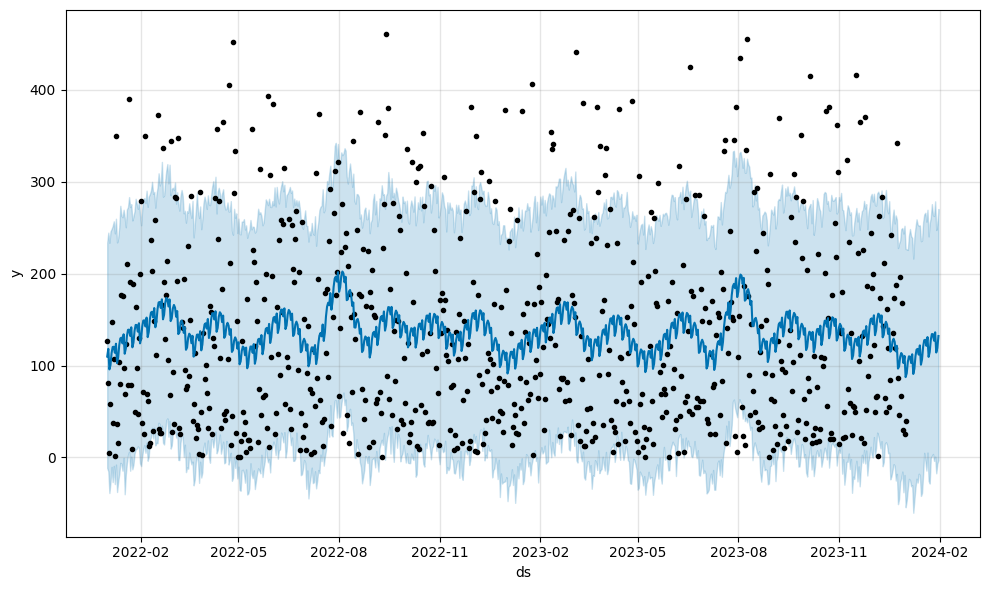

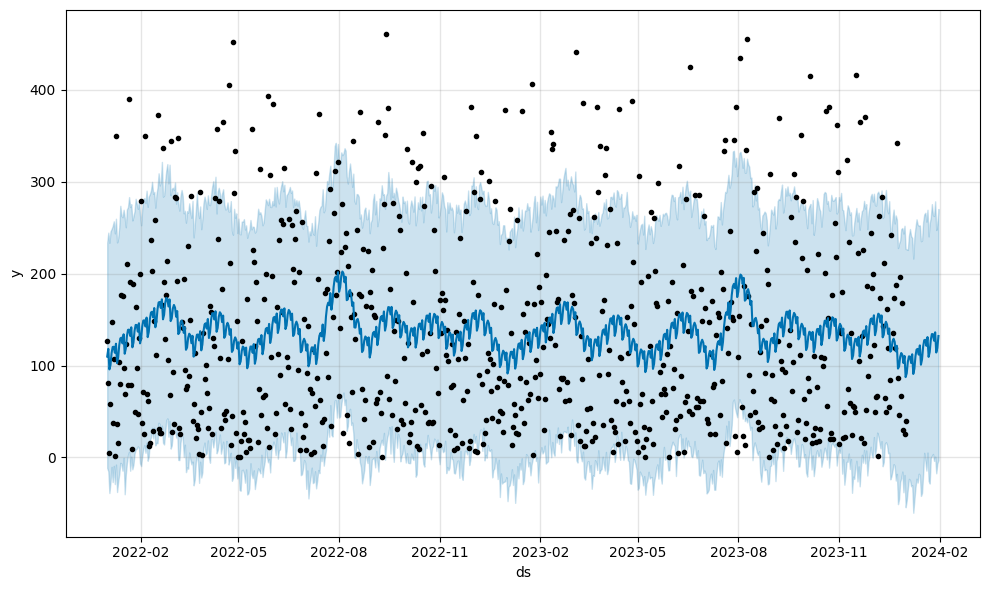

In [16]:
# Chequeo gráfico
model.plot(forecast)

## **5. Comparación con modelo Naive**

Después de entrenar el modelo, se compara con un modelo baseline: el modelo Naive. Esto permite comparar el desempeño del modelo con uno que posee una funcionalidad similar, pero más básica. Así, permite decidir en base a una sola pregunta: **¿el modelo entrenado es mejor que el modelo más sencillo usado para resolver este tipo de problemas?**

Se analiza la métrica más sencilla: _Mean Average Error_ o "MAE". En palabras sencillas, esta métrica permite cuantificar el error promedio con respecto al resultado real. Mientras más alto, mayor es el error; mientras más bajo, más cercano es al resultado real. Así, se obtuvieron los siguientes resultados aproximados:

* **MAE Prophet:** 87.5
* **MAE Naive:** 120.2

Como se puede observar, el desempeño del modelo Prophet entrenado es mejor que el del modelo Naive. En este caso, presenta un error promedio considerablemente menor. Así, podemos decir que Prophet tiene un desempeño superior a lo esperado y, por lo tanto, se acepta para un MVP.

Con el modelo entrenado y validado, el siguiente paso es traducir los resultados a lenguaje humano.

In [17]:
# 5. Comparación con modelo Naive
# Fechas que existen en histórico
df_eval = forecast.merge(
    df_prophet[['ds','y']],
    on='ds',
    how='inner'
)

from sklearn.metrics import mean_absolute_error

mae_prophet = mean_absolute_error(df_eval['y'], df_eval['yhat'])

# Baseline naive
df_eval['naive'] = df_eval['y'].shift(1)

mae_naive = mean_absolute_error(
    df_eval['y'][1:],
    df_eval['naive'][1:]
)

print("MAE Prophet:", mae_prophet)
print("MAE Naive:", mae_naive)

MAE Prophet: 87.49423097200592
MAE Naive: 120.18767123287671


## **6. Output en lenguaje humano**

Una vez que se ha validado el modelo, se traducen los resultados a lenguaje humano.

En este caso, la predicción es básica pero comprensible: el modelo entrega una predicción de la demanda promedio para el futuro a 7 días y a 30 días. Además, predice cuándo se agotarán las unidades de un producto dado el caso de que el usuario posea un stock actual de 100 unidades. Este número estándar le permitirá visualizar mejor la salud de su inventario.

Finalmente, se le entrega un gráfico que le muestra la demanda de los últimos 30 días y la demanda proyectada para los siguientes 30 días. Esto le permitirá comprender de mejor forma cómo serán las ventas esperadas para el siguiente mes y tomar decisiones en base a ello. Se le aclara también, para su tranquilidad, que el modelo ha sido entrenado en base al dataset completo que el usuario entregó, pero que el gráfico engloba solo los últimos 30 días para mayor comodidad y simplicidad.

In [18]:
# 6. Output en lenguaje humano
# Semanal
pred_7 = forecast.tail(7)['yhat'].mean().round()
pred_7 = int(pred_7)
# Mensual
pred_30 = forecast.tail(30)['yhat'].mean().round()
pred_30 = int(pred_30)
# Extrapolación simple con stock actual
stock_actual = 100
dias_stock = round(stock_actual / pred_30, 1)

In [19]:
print(f'Se proyecta una demanda promedio de {pred_30} unidades diarias para los próximos 30 días.')
print(f'Se proyecta una demanda promedio de {pred_7} unidades diarias para la próxima semana.')
print(f"Con un stock actual de {stock_actual} unidades, el inventario se agotaría en aproximadamente {dias_stock} días si la demanda proyectada se mantiene constante.")

Se proyecta una demanda promedio de 116 unidades diarias para los próximos 30 días.
Se proyecta una demanda promedio de 128 unidades diarias para la próxima semana.
Con un stock actual de 100 unidades, el inventario se agotaría en aproximadamente 0.9 días si la demanda proyectada se mantiene constante.


In [20]:
print("“El modelo fue entrenado con todo el histórico disponible. Para facilitar \nla visualización mostramos los últimos 30 días reales y \nlos próximos 30 días proyectados.”")

“El modelo fue entrenado con todo el histórico disponible. Para facilitar 
la visualización mostramos los últimos 30 días reales y 
los próximos 30 días proyectados.”


El modelo fue entrenado con todo el histórico disponible. Para facilitar 
la visualización mostramos los últimos 30 días reales y 
los próximos 30 días proyectados.


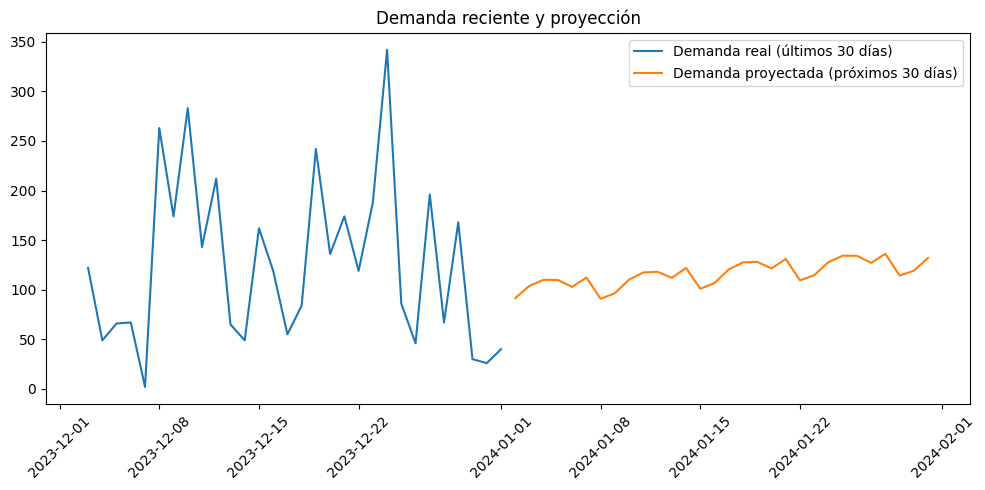

In [21]:
# Gráfico sencillo
import matplotlib.pyplot as plt
print("El modelo fue entrenado con todo el histórico disponible. Para facilitar \nla visualización mostramos los últimos 30 días reales y \nlos próximos 30 días proyectados.")

# Últimos 30 reales
historico_30 = df_prophet.tail(30)

# Próximos 30 forecast
forecast_30 = forecast.tail(30)

plt.figure(figsize=(10,5))

plt.plot(historico_30['ds'], historico_30['y'], label='Demanda real (últimos 30 días)')
plt.plot(forecast_30['ds'], forecast_30['yhat'], label='Demanda proyectada (próximos 30 días)')

plt.legend()
plt.title("Demanda reciente y proyección")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **7. Modularización lógica**

Luego, con el pipeline construido, evaluado, validado y traducido a un output entendible para los usuarios finales, se modulariza de forma lógica el código. Este paso tiene como propósito sentar las bases de la futura modularización física del código. Así, se crean las funciones y se prueba que las conexiones entre ellas sean correctas. Una vez comprobado que el flujo de la información se mantuvo indemne, se procede al último paso: la modularización física en archivos `.py` para producción.

In [22]:
def load_data(path):
    import pandas as pd
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

def filter_pyme(df, store_id, product_id):
    df_pyme_producto = df[
        (df['Store ID'] == store_id) &
        (df['Product ID'] == product_id)
    ].copy()
    return df_pyme_producto

def prepare_data(df):
    df_daily = (
        df
        .groupby('Date')['Units Sold']
        .sum()
        .reset_index()
    )

    df_daily = df_daily.rename(columns={
        'Date': 'ds',
        'Units Sold': 'y'
    })

    df_daily = df_daily.sort_values('ds')
    return df_daily

def train_model(df_prophet):
    from prophet import Prophet

    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False
    )

    model.fit(df_prophet)
    return model

def forecast(model, periods=30):
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    forecast['yhat'] = forecast['yhat'].clip(lower=0)
    return forecast

def evaluate(df_prophet, forecast):
    from sklearn.metrics import mean_absolute_error

    df_eval = forecast.merge(
        df_prophet[['ds','y']],
        on='ds',
        how='inner'
    )

    mae_prophet = mean_absolute_error(df_eval['y'], df_eval['yhat'])

    df_eval['naive'] = df_eval['y'].shift(1)

    mae_naive = mean_absolute_error(
        df_eval['y'][1:],
        df_eval['naive'][1:]
    )

    return mae_prophet, mae_naive

def generate_report(df_prophet, forecast, stock_actual=100):
    import matplotlib.pyplot as plt

    pred_30 = int(forecast.tail(30)['yhat'].mean().round())
    pred_7 = int(forecast.tail(7)['yhat'].mean().round())

    dias_stock = round(stock_actual / pred_30, 1)

    print(f"Demanda promedio próxima semana: {pred_7} unidades/día")
    print(f"Demanda promedio próximos 30 días: {pred_30} unidades/día")
    print(f"Con {stock_actual} unidades, el stock duraría aprox. {dias_stock} días.")

    historico_30 = df_prophet.tail(30)
    forecast_30 = forecast.tail(30)

    plt.figure(figsize=(10,5))
    plt.plot(historico_30['ds'], historico_30['y'])
    plt.plot(forecast_30['ds'], forecast_30['yhat'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Demanda promedio próxima semana: 128 unidades/día
Demanda promedio próximos 30 días: 116 unidades/día
Con 100 unidades, el stock duraría aprox. 0.9 días.


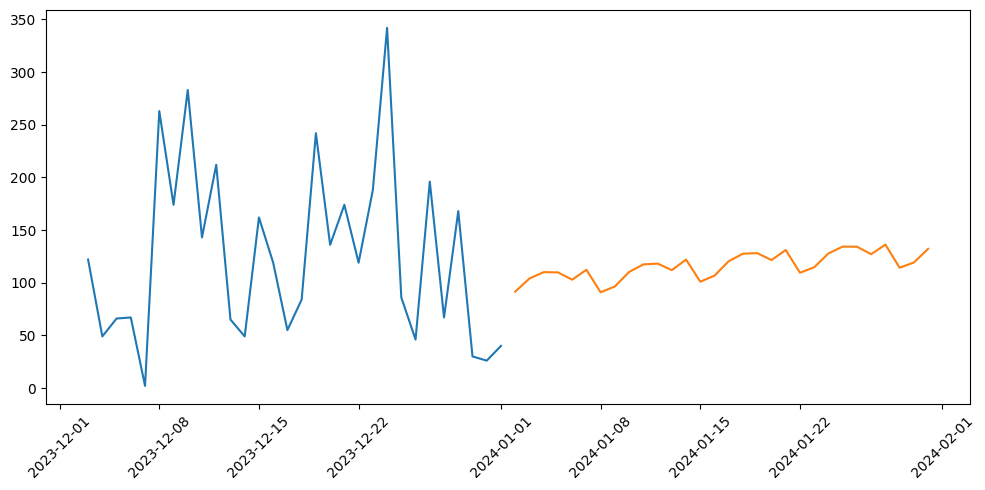

In [23]:
df = load_data('/kaggle/retail_store_inventory.csv')

df_pyme = filter_pyme(df, "S001", "P0001")

df_prophet = prepare_data(df_pyme)

model = train_model(df_prophet)

forecast_df = forecast(model, periods=30)

mae_prophet, mae_naive = evaluate(df_prophet, forecast_df)

generate_report(df_prophet, forecast_df, stock_actual=100)

## **8. Modularización física y exportación de archivos**

Finalmente, se realiza la modularización física a partir de lo logrado en la sección anterior.

La modularización física es solo la adaptación de las funciones mostradas previamente a archivos Python individuales. Es decir, se generan archivos que habilitan el trabajo en Python modular, lo que es necesario para ambientes de producción. Para lograr esto, se adaptaron las funciones de la sección anterior y se agregaron las líneas para la escritura de los archivos `.py` (es decir, `%%writefile *.py`). Después se creó el bloque necesario para la creación del `requirements.txt` (usando `%%writefile requirements.txt`). Después se comprobó su correcta exportación y, finalmente, se descargaron todos los archivos juntos.

Así, todos los archivos quedaron exportados y listos para ser subidos a un repositorio. Con esto se habilita la creación de un Front-End coherente con el "cerebro" de la aplicación y el avance del proyecto.

Al final de la sección se incluyó una prueba breve de los archivos, lo que confirma su funcionalidad de forma previa a su publicación en el repositorio oficial.

In [24]:
# data_loader.py
%%writefile data_loader.py
import pandas as pd

def load_data(path):
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

def filter_pyme(df, store_id, product_id):
    return df[
        (df['Store ID'] == store_id) &
        (df['Product ID'] == product_id)
    ].copy()


Writing data_loader.py


In [25]:
# preprocessing.py
%%writefile preprocessing.py
def prepare_data(df):
    df_daily = (
        df
        .groupby('Date')['Units Sold']
        .sum()
        .reset_index()
    )

    df_daily = df_daily.rename(columns={
        'Date': 'ds',
        'Units Sold': 'y'
    })

    return df_daily.sort_values('ds')


Writing preprocessing.py


In [26]:
# model.py
%%writefile model.py
from prophet import Prophet

def train_model(df_prophet):
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False
    )
    model.fit(df_prophet)
    return model

def make_forecast(model, periods=30):
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    forecast['yhat'] = forecast['yhat'].clip(lower=0)
    return forecast


Writing model.py


In [27]:
# evaluation.py
%%writefile evaluation.py
from sklearn.metrics import mean_absolute_error

def evaluate(df_prophet, forecast):
    df_eval = forecast.merge(
        df_prophet[['ds','y']],
        on='ds',
        how='inner'
    )

    mae_prophet = mean_absolute_error(df_eval['y'], df_eval['yhat'])

    df_eval['naive'] = df_eval['y'].shift(1)
    mae_naive = mean_absolute_error(
        df_eval['y'][1:],
        df_eval['naive'][1:]
    )

    return mae_prophet, mae_naive


Writing evaluation.py


In [28]:
# reporting.py
%%writefile reporting.py
import matplotlib.pyplot as plt

def generate_report(df_prophet, forecast, stock_actual=100):

    pred_30 = int(forecast.tail(30)['yhat'].mean().round())
    pred_7 = int(forecast.tail(7)['yhat'].mean().round())
    dias_stock = round(stock_actual / pred_30, 1)

    print(f"Demanda próxima semana: {pred_7}")
    print(f"Demanda próximos 30 días: {pred_30}")
    print(f"Stock dura aprox: {dias_stock} días")

    historico_30 = df_prophet.tail(30)
    forecast_30 = forecast.tail(30)

    plt.figure(figsize=(10,5))
    plt.plot(historico_30['ds'], historico_30['y'])
    plt.plot(forecast_30['ds'], forecast_30['yhat'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Writing reporting.py


In [29]:
# main.py
%%writefile main.py
from data_loader import load_data, filter_pyme
from preprocessing import prepare_data
from model import train_model, make_forecast
from evaluation import evaluate
from reporting import generate_report


def main():

    df = load_data("retail_store_inventory.csv")

    df_pyme = filter_pyme(df, "S001", "P0001")

    df_prophet = prepare_data(df_pyme)

    model = train_model(df_prophet)

    forecast_df = make_forecast(model, periods=30)

    mae_prophet, mae_naive = evaluate(df_prophet, forecast_df)

    print("MAE Prophet:", mae_prophet)
    print("MAE Naive:", mae_naive)

    generate_report(df_prophet, forecast_df, stock_actual=100)


if __name__ == "__main__":
    main()


Writing main.py


In [30]:
# app.py
%%writefile app.py
from fastapi import FastAPI, UploadFile, File
import shutil
import os

from data_loader import load_data
from preprocessing import prepare_data
from model import train_model, make_forecast

app = FastAPI()

@app.post("/predict")
async def predict(file: UploadFile = File(...)):

    temp_path = "temp.csv"

    # Guardar archivo temporal
    with open(temp_path, "wb") as buffer:
        shutil.copyfileobj(file.file, buffer)

    # Procesar
    df = load_data(temp_path)
    df_prophet = prepare_data(df)
    model = train_model(df_prophet)
    forecast = make_forecast(model, periods=30)

    pred_30 = int(forecast.tail(30)['yhat'].mean().round())

    # (opcional) borrar archivo temporal
    if os.path.exists(temp_path):
        os.remove(temp_path)

    return {"prediccion_30_dias": pred_30}


Writing app.py


In [31]:
# requirements.txt
%%writefile requirements.txt
fastapi
uvicorn
pandas
prophet
scikit-learn
matplotlib

Writing requirements.txt


In [32]:
!pwd
!ls

/content
app.py		df_pyme_MVP.csv  main.py   preprocessing.py  requirements.txt
data_loader.py	evaluation.py	 model.py  reporting.py      sample_data


In [34]:
from google.colab import files

files_to_download = [
    "data_loader.py",
    "evaluation.py",
    "main.py",
    "preprocessing.py",
    "model.py",
    "reporting.py",
    "app.py",
    "df_pyme_MVP.csv",
    "requirements.txt"
]

for file_name in files_to_download:
    files.download(file_name)

print(f"¡Descarga exitosa! \nArchivos descargados: \n{files_to_download}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

¡Descarga exitosa! 
Archivos descargados: 
['data_loader.py', 'evaluation.py', 'main.py', 'preprocessing.py', 'model.py', 'reporting.py', 'app.py', 'df_pyme_MVP.csv', 'requirements.txt']


In [42]:
# Prueba sencilla de modularización
# Instalación de dependencias (reproducibilidad del entorno)
!pip install -r requirements.txt
# Prueba de módulos Python
!python data_loader.py
!python model.py
!python main.py

18:12:24 - cmdstanpy - INFO - Chain [1] start processing
18:12:24 - cmdstanpy - INFO - Chain [1] done processing
MAE Prophet: 87.49423097200592
MAE Naive: 120.18767123287671
Demanda próxima semana: 128
Demanda próximos 30 días: 116
Stock dura aprox: 0.9 días
Figure(1000x500)


## **9. Avances futuros proyectados**

Como mejoras futuras, se han planteado varias funcionalidades que se podrían añadir al producto, para así proveer un mejor servicio al usuario final. Dichas funcionalidades son numerosas. Aquí se muestran solamente aquellas que ya tienen líneas de código planeadas, pero que aún no se planea integrar o adaptar de forma armónica al MVP actual.

Así, las mejoras proyectadas son:
* Front-End sencillo con Streamlit
* Funcionalidad de Método Analítico
* Funcionalidad de Método de Monte Carlo

Con respecto a las mejoras mencionadas, a continuación se provee una explicación más detallada.
* **Front-End con Streamlit:** esta funcionalidad proveería un Front-End sencillo que puede servir como primera aproximación a un FE funcional, habilitando pruebas sumamente sencillas de funcionalidad. Eventualmente podría ser reemplazado por el FE ya desarrollado por otros miembros del equipo.
* **Funcionalidad de Método Analítico:** esta funcionalidad permitiría responder mejor la pregunta "¿Cuál es la probabilidad estadística de quedarme sin stock?". A partir del forecast de Prophet se puede obtener el intervalo de confianza (`yhat_upper - yhat_lower`), lo que se puede usar para la desviación estándar y luego, asumiendo una distribución normal, calcular el punto en el que la demanda supera al stock actual (`P(demanda total > stock_actual)`).
* **Funcionalidad de Método de Monte Carlo:** esta funcionalidad permitiría modelar de forma más precisa aún el riesgo de que la Pyme se quede sin stock. El Método de Monte Carlo simula miles de escenarios, luego genera ventas aleatorias según media y desviación, suma la demanda simulada y calculan **cuántas veces supera el stock.** Así, el riesgo que se discutió en el punto anterior se calcula de una forma aún más avanzada. De esta forma, con ambas funcionalidades se obtendría una predicción más precisa y una estimación del riesgo más fiel a la realidad. Finalmente, este cálculo se complementa con una función de reposición, que explicita la cantidad necesaria para realizar una reposición del producto en cuestión.

Esas son las tres funcionalidades proyectadas de forma más concreta. Otras posibles funcionalidades se encuentran en desarrollo.

In [35]:
# streamlit_app.py
%%writefile streamlit_app.py
import streamlit as st
import pandas as pd

from data_loader import load_data
from preprocessing import prepare_data
from model import train_model, make_forecast

st.title("Forecast de Demanda para PYMEs")

uploaded_file = st.file_uploader("Sube tu CSV", type=["csv"])

if uploaded_file is not None:

    df = pd.read_csv(uploaded_file)
    df['Date'] = pd.to_datetime(df['Date'])

    df_prophet = prepare_data(df)

    model = train_model(df_prophet)

    forecast = make_forecast(model, periods=30)

    pred_30 = int(forecast.tail(30)['yhat'].mean().round())

    st.success(f"Demanda promedio proyectada próximos 30 días: {pred_30} unidades/día")

    st.line_chart(
        forecast[['ds','yhat']].set_index('ds').tail(60)
    )


Writing streamlit_app.py


In [36]:
# requirements.txt
%%writefile requirements.txt
fastapi
uvicorn
pandas
prophet
scikit-learn
matplotlib
streamlit

Overwriting requirements.txt


In [37]:
streamlit_to_download = [
    "streamlit_app.py",
    "requirements.txt"
]

for file_name in streamlit_to_download:
    files.download(file_name)

print(f"¡Descarga exitosa! \nArchivos descargados: \n{streamlit_to_download}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

¡Descarga exitosa! 
Archivos descargados: 
['streamlit_app.py', 'requirements.txt']


In [ ]:
# analytic_stockout.py
import numpy as np
from scipy.stats import norm
import pandas as pd

def estimate_prob_stockout_analytic(forecast_df, stock_current):
    """
    forecast_df: DataFrame con columnas ['ds','yhat','yhat_lower','yhat_upper']
    stock_current: int o float
    Retorna: prob_pct, total_mean, total_std
    """
    means = forecast_df['yhat'].astype(float).values
    lowers = forecast_df['yhat_lower'].astype(float).values
    uppers = forecast_df['yhat_upper'].astype(float).values

    # Estima desviación diaria a partir del intervalo de confianza (aprox. 95%)
    stds = np.maximum((uppers - lowers) / (2 * 1.96), 1e-6)

    total_mean = means.sum()
    total_var = np.sum(stds**2)
    total_std = np.sqrt(total_var)

    # Probabilidad de que demanda total supere stock_current
    prob = 1 - norm.cdf(stock_current, loc=total_mean, scale=total_std)
    prob_pct = float(np.clip(prob * 100, 0, 100))

    return prob_pct, float(total_mean), float(total_std)

# Ejemplo de uso:
# df_fcst = pd.DataFrame([...])  # debe contener yhat, yhat_lower, yhat_upper
# prob_pct, mu, sigma = estimate_prob_stockout_analytic(df_fcst, stock_current=40)


In [ ]:
# montecarlo_stockout.py
import numpy as np
import pandas as pd

def estimate_prob_stockout_montecarlo(forecast_df, stock_current, n_sims=5000, dist='normal', random_seed=42):
    """
    forecast_df: DataFrame con columnas ['ds','yhat','yhat_lower','yhat_upper']
    stock_current: int o float
    n_sims: número de simulaciones
    dist: 'normal' o 'lognormal'
    Retorna: prob_pct, total_mean, total_std
    """
    rng = np.random.default_rng(random_seed)
    means = forecast_df['yhat'].astype(float).values
    lowers = forecast_df['yhat_lower'].astype(float).values
    uppers = forecast_df['yhat_upper'].astype(float).values

    stds = np.maximum((uppers - lowers) / (2 * 1.96), 1e-6)
    days = len(means)

    # Simular matriz (n_sims x days)
    if dist == 'normal':
        sims = rng.normal(loc=means, scale=stds, size=(n_sims, days))
        sims = np.clip(sims, a_min=0, a_max=None)  # no ventas negativas
    else:
        # lognormal: parametrizar a partir de media y std aproximada
        # evita valores negativos y modela asimetría
        mu = np.log(np.maximum(means, 1e-6)) - 0.5 * (np.log(1 + (stds/np.maximum(means,1e-6))**2))
        sigma = np.sqrt(np.log(1 + (stds/np.maximum(means,1e-6))**2))
        sims = rng.lognormal(mean=mu, sigma=sigma, size=(n_sims, days))
        sims = np.clip(sims, a_min=0, a_max=None)

    total_demand = sims.sum(axis=1)
    prob = np.mean(total_demand > stock_current)
    prob_pct = float(np.clip(prob * 100, 0, 100))

    total_mean = float(means.sum())
    total_std = float(np.sqrt(np.sum(stds**2)))

    return prob_pct, total_mean, total_std

# Ejemplo:
# prob_pct, mu, sigma = estimate_prob_stockout_montecarlo(df_fcst, stock_current=40, n_sims=10000)


In [ ]:
# replenish.py
def recommend_replenish(mu, sigma, stock_current, k=1.2):
    """
    mu: demanda proyectada total
    sigma: desviación total
    k: factor de seguridad (ajustable)
    """
    needed = max(0, int(round(mu - stock_current + k * sigma)))
    return needed


De esta forma, el presente notebook ha mostrado el pipeline completo de la producción básica realizada para el MVP. Se mostró la lógica detrás del producto, la exploración inicial, la configuración y prueba del modelo, su modularización para producción y futuras mejoras proyectadas para una siguiente versión.

El presente notebook demuestra la viabilidad técnica del MVP y sienta las bases para su evolución hacia una solución productiva escalable.

Con esto concluye el notebook.

---

_Equipo **SmartStock AI**_  
_Febrero 2026_  
_Para **Hackathon NODO 2026**_